In [1]:
# prepare a single trend raster from annual LSP rasters of both MODIS-EVI and standard MCD12Q2
# Trends are analysed using the Mann-Kendall test and slope is calculated using the Sen's slope


import os
import pandas as pd 
import numpy as np  
import rasterio as rio
import xarray as xr 
import rioxarray as rxr 
import matplotlib.pyplot as plt 
import glob
import pymannkendall as mk


In [2]:
def mk_wrapper(series):
    valid_mask = ~np.isnan(series)
    valid_count = valid_mask.sum()
    
    if valid_count < 11:
        return np.array([np.nan, np.nan])
    
    clean_series = series[valid_mask]
    
    try:
        res = mk.original_test(clean_series, alpha=0.05)
        return np.array([float(res.p), float(res.slope)])
    except:
        return np.array([np.nan, np.nan])

def process_lsp_trends(data_product, metric, base_path=r"..\Data\Scaled_LSP_Rasters",
                             alpha=0.05, save_outputs=True):
    
    # 1. Load raster stack
    stack_path = os.path.join(base_path, metric)
    files = sorted(glob.glob(os.path.join(stack_path, "*.tif")))
    dates = [pd.to_datetime(("20"+ os.path.basename(f)[-6:-4] ), format='%Y') for f in files]
    if len(files) == 0:
        raise FileNotFoundError(f"No files found in: {stack_path}")
    
    print(f"Found {len(files)} raster files")
        
    print("Loading and stacking rasters...")
    stack = xr.concat(
        [rxr.open_rasterio(f, masked=True) for f in files],
        dim=pd.Index(dates, name='time'),
        join='exact'
    )
    stack = stack.where(stack >= 0)
    stack_3d = stack.isel(band=0)
    
    # 2. Run Mann-Kendall test
    print("Running Mann-Kendall trend analysis...")
    mk_result = xr.apply_ufunc(
        mk_wrapper, stack_3d,
        input_core_dims=[['time']], output_core_dims=[['stat']],
        vectorize=True, dask='parallelized', output_dtypes=[float],
        dask_gufunc_kwargs={'output_sizes': {'stat': 2}}
    )
    
    p_value = mk_result.isel(stat=0)
    slope_raw = mk_result.isel(stat=1)
    
    # 3. Filter for significance
    significant_mask = p_value < alpha
    slope_significant = slope_raw.where(significant_mask)
    
    # Calculate statistics BEFORE filling NaNs with -999
    total_pixels = int((~np.isnan(slope_raw)).sum().item())
    significant_pixels = int((~np.isnan(slope_significant)).sum().item())
    
    print(f"\nSignificance filtering (p < {alpha}):")
    print(f"  Total valid pixels: {total_pixels}")
    print(f"  Significant pixels: {significant_pixels} ({100*significant_pixels/total_pixels:.1f}%)")
    
    # 4. Save outputs
    if save_outputs:
        output_dir = r"C:\Users\A S U S\Documents\Study\Land Surface Phenology\LSP_WS\Data\Trend_Rasters"
        os.makedirs(output_dir, exist_ok=True)
        
        raw_file = os.path.join(output_dir, f"{data_product}_{metric}_mk_raw.tif")
        significant_file = os.path.join(output_dir, f"{data_product}_{metric}_mk_significant.tif")
        
        print(f"\nSaving outputs to: {output_dir}")
        
        slope_raw = slope_raw.fillna(-999).rio.write_nodata(-999)
        slope_raw.rio.to_raster(raw_file, driver='GTiff', compress='LZW')
        print(f"  ✓ {os.path.basename(raw_file)}")
        
        slope_significant = slope_significant.fillna(-999).rio.write_nodata(-999)
        slope_significant.rio.to_raster(significant_file, driver='GTiff', compress='LZW')
        print(f"  ✓ {os.path.basename(significant_file)}")
        p_value = p_value.fillna(-999).rio.write_nodata(-999)
    
    return {
        'p_value': p_value,
        'slope_raw': slope_raw,
        'slope_significant': slope_significant
    }

def plot_trend_results(results, title_prefix=""):
    """Plot trend analysis results in 2x2 grid"""
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    results['slope_raw'].plot(ax=axes[0, 0], cmap='RdBu_r', robust=True)
    axes[0, 0].set_title(f"{title_prefix} Sen's Slope (Raw)")
    
    results['p_value'].plot(ax=axes[0, 1], cmap='YlOrRd_r', vmin=0, vmax=0.1)
    axes[0, 1].set_title(f"{title_prefix} P-value")
    
    results['slope_significant'].plot(ax=axes[1, 0], cmap='RdBu_r', robust=True)
    axes[1, 0].set_title(f"{title_prefix} Significant Trends (p < 0.05)")

    
    plt.tight_layout()
    plt.show()

Found 24 raster files
Loading and stacking rasters...
Running Mann-Kendall trend analysis...

Significance filtering (p < 0.05):
  Total valid pixels: 4613542
  Significant pixels: 426743 (9.2%)

Saving outputs to: C:\Users\A S U S\Documents\Study\Land Surface Phenology\LSP_WS\Data\Trend_Rasters
  ✓ mod_sos_mk_raw.tif
  ✓ mod_sos_mk_significant.tif
Processed MOD SOS
Found 24 raster files
Loading and stacking rasters...
Running Mann-Kendall trend analysis...

Significance filtering (p < 0.05):
  Total valid pixels: 4735159
  Significant pixels: 449317 (9.5%)

Saving outputs to: C:\Users\A S U S\Documents\Study\Land Surface Phenology\LSP_WS\Data\Trend_Rasters
  ✓ mod_eos_mk_raw.tif
  ✓ mod_eos_mk_significant.tif
Processed MOD EOS
Found 24 raster files
Loading and stacking rasters...
Running Mann-Kendall trend analysis...

Significance filtering (p < 0.05):
  Total valid pixels: 4735412
  Significant pixels: 516399 (10.9%)

Saving outputs to: C:\Users\A S U S\Documents\Study\Land Surface 

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

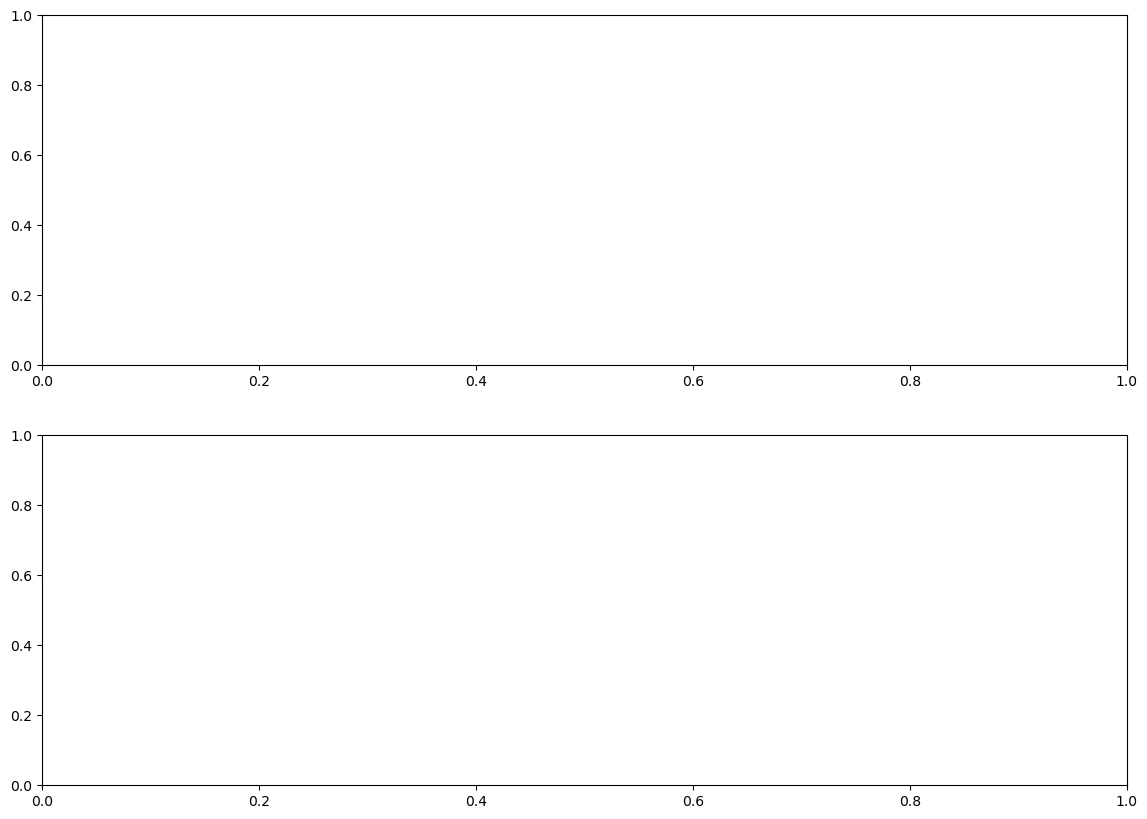

In [3]:
# === PROCESS MOD DATA ===

mod_sos_results = process_lsp_trends(
    data_product='mod',
    base_path = r"..\Data\Scaled_LSP_Rasters",
    metric='sos',
    alpha=0.05,
    save_outputs=True
)
print("Processed MOD SOS")

mod_eos_results = process_lsp_trends(
    data_product='mod',
    base_path = r"..\Data\Scaled_LSP_Rasters",
    metric='eos',
    alpha=0.05,
    save_outputs=True
)
print("Processed MOD EOS")

mod_los_results = process_lsp_trends(
    data_product='mod',
    base_path = r"..\Data\Scaled_LSP_Rasters",
    metric='los',
    alpha=0.05,
    save_outputs=True
)
print("Processed MOD LOS")

mod_pos_results = process_lsp_trends(
    data_product='mod',
    base_path = r"..\Data\Scaled_LSP_Rasters",
    metric='pos',
    alpha=0.05,
    save_outputs=True
)
print("Processed MOD POS")

# Visualize results
plot_trend_results(mod_sos_results, title_prefix="MOD SOS -")

In [4]:
#Process MCD  data

mcd_sos_results = process_lsp_trends(
    data_product = 'mcd',
    metric = 'sos',
    base_path = r"..\Data\Standard_Modis_LSP",
    alpha = 0.05,
    save_outputs = True
)
print("Processed MCD SOS")

mcd_eos_results = process_lsp_trends(
    data_product = 'mcd',
    metric = 'eos',
    base_path = r"..\Data\Standard_Modis_LSP",
    alpha = 0.05,
    save_outputs = True
)
print("Processed MCD EOS")

mcd_los_results = process_lsp_trends(
    data_product = 'mcd',
    metric = 'los',
    base_path = r"..\Data\Standard_Modis_LSP",
    alpha = 0.05,
    save_outputs = True
)
print("Processed MCD LOS")

mcd_pos_results = process_lsp_trends(
    data_product = 'mcd',
    metric = 'pos',
    base_path = r"..\Data\Standard_Modis_LSP",
    alpha = 0.05,
    save_outputs = True
)
print("Processed MCD POS")

#plot_trend_results(mcd_sos_results, title_prefix="MCD - ")

Found 24 raster files
Loading and stacking rasters...
Running Mann-Kendall trend analysis...

Significance filtering (p < 0.05):
  Total valid pixels: 888015
  Significant pixels: 80149 (9.0%)

Saving outputs to: C:\Users\A S U S\Documents\Study\Land Surface Phenology\LSP_WS\Data\Trend_Rasters
  ✓ mcd_sos_mk_raw.tif
  ✓ mcd_sos_mk_significant.tif
Processed MCD SOS
Found 24 raster files
Loading and stacking rasters...
Running Mann-Kendall trend analysis...

Significance filtering (p < 0.05):
  Total valid pixels: 895535
  Significant pixels: 118727 (13.3%)

Saving outputs to: C:\Users\A S U S\Documents\Study\Land Surface Phenology\LSP_WS\Data\Trend_Rasters
  ✓ mcd_eos_mk_raw.tif
  ✓ mcd_eos_mk_significant.tif
Processed MCD EOS
Found 24 raster files
Loading and stacking rasters...
Running Mann-Kendall trend analysis...

Significance filtering (p < 0.05):
  Total valid pixels: 899115
  Significant pixels: 106798 (11.9%)

Saving outputs to: C:\Users\A S U S\Documents\Study\Land Surface Phe